## Defining configuration

Install lime for explanations

In [0]:
import os
import tarfile
from google.colab import drive

drive_path = ('drive')
drive.mount(os.path.join(os.getcwd(), drive_path))
tar = tarfile.open("/content/drive/My Drive/Colab Notebooks/datasets/data-covid-py.tar.gz", "r")
tar.extractall(os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
config = {
  'PATHS': {
    'RAW_DATA': os.path.join(os.getcwd(), 'data'),
    'COVID_CHEST_XRAY_DATA': os.path.join(os.getcwd(), 'data', 'covid-chestxray-dataset'),
    'CHEST_XRAY_8_DATA': os.path.join(os.getcwd(), 'data', 'ChestX-ray8'),
    'PROCESSED_DATA': os.path.join(os.getcwd(), 'data', 'processed'),
    'TRAIN_SET': os.path.join(os.getcwd(), 'data', 'processed', 'train_set.csv'),
    'VAL_SET': os.path.join(os.getcwd(), 'data', 'processed', 'val_set.csv'),
    'TEST_SET': os.path.join(os.getcwd(), 'data', 'processed', 'test_set.csv'),
    'IMAGES': os.path.join(os.getcwd(), drive_path, 'My Drive', 'Colab Notebooks', 'output', 'documents', 'generated_images'),
    'LOGS': os.path.join(os.getcwd(), 'results', 'logs'),
    'MODELS_FOLDER': os.path.join(os.getcwd(), drive_path, 'My Drive', 'Colab Notebooks', 'models', 'model_covid'),
    'MODEL_WEIGHTS': os.path.join(os.getcwd(), drive_path, 'My Drive', 'Colab Notebooks', 'models', 'model_covid', 'model_weights20200531-103213.index'),
    'MODEL_TO_LOAD': os.path.join(os.getcwd(), drive_path, 'My Drive', 'Colab Notebooks', 'models', 'model_covid', 'model20200531-180948.h5'),
    'OUTPUT_CLASS_INDICES': os.path.join(os.getcwd(), 'data', 'interpretability', 'output_class_indices.pkl'),
    'LIME_EXPLAINER': os.path.join(os.getcwd(), 'data', 'interpretability', 'lime_explainer.pkl'),
  },
  'DATA': {
    'IMG_DIM': [
      512,
      512
    ],
    'VIEW': 'PA',
    'VAL_SPLIT_PERCENT': 0.08,
    'TEST_SPLIT_PERCENT': 0.1,
    'NUM_CHEST_XRAY_8_IMAGES': 1000,
    'CLASSES': [
      'COVID-19',
      'OTHER'
    ],
    'OTHER_CONTAINS_ONLY_HEALTHY': True,
    
    # One of {'class_weight', 'reduce'}
    'CLASS_BALANCE_STRATEGY': 'reduce'      
  },
  'TRAIN': {
    'BATCH_SIZE': 32,
    'EPOCHS': 150,
    'THRESHOLDS': 0.5,
    'ENABLE_EARLY_STOPPING': False,
    'PATIENCE_FOR_EARLY_STOPPING': 7,
    'NUM_GPUS': 0
  },
  'NN': {
    'KERNEL_SIZE': '(3,3)',
    'STRIDES': '(1,1)',
    'INIT_FILTERS': 16,
    'FILTER_EXP_BASE': 3,
    'MAXPOOL_SIZE': '(2,2)',
    'CONV_BLOCKS': 3,
    'NODES_DENSE0': 128,
    'LR': 1e-05,
    'OPTIMIZER': 'adam',
    'DROPOUT': 0.4,
    'L2_LAMBDA': 0.0001
  },
  'LIME': {
    'KERNEL_WIDTH': 1.75,
    'FEATURE_SELECTION': 'lasso_path',
    'NUM_FEATURES': 1000,
    'NUM_SAMPLES': 1000,
    'COVID_ONLY': False
  },
  'PREDICTION': {
    'THRESHOLD': 0.5
  }
}

## Preprocessing
### Importing dependencies

In [0]:
from pathlib import Path
import re

for path in config['PATHS']:
    if not bool(re.match('^.*\.[a-zA-Z0-9]+$', config['PATHS'][path])):
        Path(config['PATHS'][path]).mkdir(parents=True, exist_ok=True)
    else:
        splitted_path = config['PATHS'][path][:config['PATHS'][path].rfind('/')]
        Path(splitted_path).mkdir(parents=True, exist_ok=True)

In [0]:
import pandas as pd

covid_chest_xray_path = config['PATHS']['COVID_CHEST_XRAY_DATA']
chest_xray_8_path = config['PATHS']['CHEST_XRAY_8_DATA']

covid_chest_xray_df = pd.read_csv(os.path.join(covid_chest_xray_path, 'metadata.csv'))
covid_chest_xray_df['filename'] = [os.path.join(covid_chest_xray_path, 'images', row) for row in covid_chest_xray_df['filename'].astype(str)]

covid_views_cxrs_df = covid_chest_xray_df['view'].str.match(config['DATA']['VIEW'])
covid_pos_df = covid_chest_xray_df['finding'].str.match('COVID-19')
covid_df = covid_chest_xray_df[covid_pos_df & covid_views_cxrs_df] 

chest_xray_8_df = pd.read_csv(os.path.join(chest_xray_8_path, 'subset.csv'))
num_chest_xray_8_imgs = config['DATA']['NUM_CHEST_XRAY_8_IMAGES']
chest_xray_8_normal_df = chest_xray_8_df[chest_xray_8_df['Finding Labels'].str.match('No Finding')]
chest_xray_8_pneum_df = chest_xray_8_df[chest_xray_8_df['Finding Labels'].str.match('(?!No Finding)')]

chest_xray_8_normal_sample_df = chest_xray_8_normal_df.sample(frac = num_chest_xray_8_imgs / chest_xray_8_normal_df.shape[0], random_state=num_chest_xray_8_imgs)

chest_xray_8_pneum_sample_df = chest_xray_8_pneum_df.sample(frac = num_chest_xray_8_imgs / chest_xray_8_pneum_df.shape[0], random_state=num_chest_xray_8_imgs)

if config['DATA']['OTHER_CONTAINS_ONLY_HEALTHY']:
  chest_xray_8_df = chest_xray_8_normal_sample_df
else:
  chest_xray_8_df = pd.concat([chest_xray_8_normal_sample_df, chest_xray_8_pneum_sample_df], axis=0)

chest_xray_8_df['filename'] = [os.path.join(chest_xray_8_path, row) for row in chest_xray_8_df['Image Index'].astype(str)]

In [0]:
covid_df['label'] = 'COVID-19'
chest_xray_8_df['label'] = 'OTHER'

chest_xray_8_selected_df = None
if config['DATA']['CLASS_BALANCE_STRATEGY'] == 'reduce':
  chest_xray_8_selected_df = chest_xray_8_df.head(covid_df.shape[0])
else:
  chest_xray_8_selected_df = chest_xray_8_df

file_df = pd.concat(
        [covid_df[['filename', 'label']],
        chest_xray_8_selected_df[['filename', 'label']]], axis=0)         

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
from sklearn.model_selection import train_test_split

validation_split_size = config['DATA']['VAL_SPLIT_PERCENT']
test_split_size = config['DATA']['TEST_SPLIT_PERCENT']
file_df_train, file_df_test = train_test_split(file_df, test_size=test_split_size, stratify=file_df['label'], random_state=42)
relative_validation_split_size = validation_split_size / (1 - test_split_size)
file_df_train, file_df_val = train_test_split(file_df_train, test_size=relative_validation_split_size,
                                                    stratify=file_df_train['label'], random_state=42)

if not os.path.exists(config['PATHS']['PROCESSED_DATA']):
    os.makedirs(config['PATHS']['PROCESSED_DATA'])
file_df_train.to_csv(config['PATHS']['TRAIN_SET'])
file_df_val.to_csv(config['PATHS']['VAL_SET'])
file_df_test.to_csv(config['PATHS']['TEST_SET'])

In [0]:
import datetime
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(config['PATHS']['LOGS'], 'training', cur_date)
if not os.path.exists(os.path.join(config['PATHS']['LOGS'], 'training')):
    os.makedirs(os.path.join(config['PATHS']['LOGS'], 'training'))

data = {}
data['TRAIN'] = pd.read_csv(config['PATHS']['TRAIN_SET'])
data['VAL'] = pd.read_csv(config['PATHS']['VAL_SET'])
data['TEST'] = pd.read_csv(config['PATHS']['TEST_SET'])

callbacks = []
if config['TRAIN']['ENABLE_EARLY_STOPPING']:
  early_stopping = EarlyStopping(
    monitor='val_loss',
    verbose=1, 
    patience=config['TRAIN']['PATIENCE_FOR_EARLY_STOPPING'], 
    mode='min', 
    restore_best_weights=False)
  callbacks.append(early_stopping)
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks.append(tensorboard)

In [0]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import dill

train_img_gen = ImageDataGenerator(rotation_range=10, samplewise_std_normalization=True, samplewise_center=True)
val_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)
test_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)

img_shape = tuple(config['DATA']['IMG_DIM'])

class_mode = 'categorical'
train_generator = train_img_gen.flow_from_dataframe(
    dataframe=data['TRAIN'],
    x_col="filename",
    y_col='label',
    target_size=img_shape,
    batch_size=config['TRAIN']['BATCH_SIZE'],
    class_mode=class_mode,
    validate_filenames=True)
val_generator = val_img_gen.flow_from_dataframe(
    dataframe=data['VAL'],
    x_col="filename",
    y_col='label',
    target_size=img_shape,
    batch_size=config['TRAIN']['BATCH_SIZE'],
    class_mode=class_mode,
    validate_filenames=True)
test_generator = test_img_gen.flow_from_dataframe(
    dataframe=data['TEST'],
    x_col="filename",
    y_col='label',
    target_size=img_shape,
    batch_size=config['TRAIN']['BATCH_SIZE'],
    class_mode=class_mode,
    validate_filenames=True,
    shuffle=False)

dill.dump(test_generator.class_indices, open(config['PATHS']['OUTPUT_CLASS_INDICES'], 'wb+'))

histogram = np.bincount(np.array(train_generator.labels).astype(int))

class_weight = None
if config['DATA']['CLASS_BALANCE_STRATEGY'] == 'class_weight':
  class_multiplier_list = [min(histogram) / max(histogram)]
  class_multiplier_list.insert(int(histogram[0] > histogram[1]), 1.0)

  class_multiplier = [
          class_multiplier_list[config['DATA']['CLASSES'].index(c)]
              for c in test_generator.class_indices
  ]

  weights = [(1.0 / len(histogram)) * sum(histogram) / histogram[i] for i in range(len(histogram))]

  class_weight = {i: class_multiplier[i] for i in range(len(histogram))}  

Found 250 validated image filenames belonging to 2 classes.
Found 25 validated image filenames belonging to 2 classes.
Found 31 validated image filenames belonging to 2 classes.


In [0]:
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, AUC
from tensorflow_addons.metrics import F1Score
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Input, LeakyReLU, Activation, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import Constant
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.utils import multi_gpu_model

covid_class_idx = test_generator.class_indices['COVID-19']   
thresholds = 1.0 / len(config['DATA']['CLASSES'])
metrics = ['accuracy', CategoricalAccuracy(name='c_accuracy'),
    Precision(name='precision', thresholds=thresholds, class_id=covid_class_idx),
    Recall(name='recall', thresholds=thresholds, class_id=covid_class_idx),
    AUC(name='auc'),
    F1Score(name='f1score', threshold=thresholds, num_classes=len(config['DATA']['CLASSES']))]

input_shape = config['DATA']['IMG_DIM'] + [3]
num_gpus = config['TRAIN']['NUM_GPUS']

model_config = config['NN']

nodes_dense0 = model_config['NODES_DENSE0']
lr = model_config['LR']
dropout = model_config['DROPOUT']
l2_lambda = model_config['L2_LAMBDA']

if model_config['OPTIMIZER'] == 'sgd':
    optimizer = SGD(learning_rate=lr)
else:
    optimizer = Adam(learning_rate=lr)

histogram = np.bincount([config['DATA']['CLASSES'].index(label) for label in data['TRAIN']['label'].astype(str)])
output_bias = np.log([histogram[i] / (np.sum(histogram) - histogram[i]) for i in range(histogram.shape[0])])

# Set output bias
if output_bias is not None:
    output_bias = Constant(output_bias)
print("MODEL CONFIG: ", model_config)

X_input = Input(input_shape, name='input_img')
base_model = ResNet101V2(include_top=False, weights='imagenet', input_shape=input_shape, input_tensor=X_input)
base_model.trainable = False
X = base_model.output

# Add custom top
X = GlobalMaxPooling2D()(X)
X = Dropout(dropout)(X)
X = Dense(nodes_dense0, kernel_initializer='he_uniform', activity_regularizer=l2(l2_lambda))(X)
X = LeakyReLU()(X)
X = Dense(len(config['DATA']['CLASSES']), bias_initializer=output_bias)(X)
Y = Activation('softmax', dtype='float32', name='output')(X)

model = Model(inputs=X_input, outputs=Y)
model.summary()

if num_gpus >= 2:
    model = multi_gpu_model(model, gpus=num_gpus)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)

MODEL CONFIG:  {'KERNEL_SIZE': '(3,3)', 'STRIDES': '(1,1)', 'INIT_FILTERS': 16, 'FILTER_EXP_BASE': 3, 'MAXPOOL_SIZE': '(2,2)', 'CONV_BLOCKS': 3, 'NODES_DENSE0': 128, 'LR': 1e-05, 'OPTIMIZER': 'adam', 'DROPOUT': 0.4, 'L2_LAMBDA': 0.0001}
171319296/171317808 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_img[0][0]                  
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]       

In [0]:
from math import ceil

steps_per_epoch = ceil(train_generator.n / train_generator.batch_size)
val_steps = ceil(val_generator.n / val_generator.batch_size)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=config['TRAIN']['EPOCHS'],
                                validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks,
                                verbose=True, class_weight=class_weight)

Epoch 1/150
8/8 [==============================] - 25s 3s/step - loss: 50.1646 - accuracy: 0.4680 - c_accuracy: 0.4680 - precision: 0.4706 - recall: 0.5120 - auc: 0.4661 - f1score: 0.4670 - val_loss: 21.3661 - val_accuracy: 0.6000 - val_c_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.7500 - val_auc: 0.6464 - val_f1score: 0.5942
Epoch 2/150
8/8 [==============================] - 23s 3s/step - loss: 46.0837 - accuracy: 0.5440 - c_accuracy: 0.5440 - precision: 0.5433 - recall: 0.5520 - auc: 0.5546 - f1score: 0.5440 - val_loss: 20.3982 - val_accuracy: 0.6000 - val_c_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.7500 - val_auc: 0.6448 - val_f1score: 0.5942
Epoch 3/150
8/8 [==============================] - 23s 3s/step - loss: 43.9007 - accuracy: 0.5440 - c_accuracy: 0.5440 - precision: 0.5455 - recall: 0.5280 - auc: 0.5552 - f1score: 0.5439 - val_loss: 20.0375 - val_accuracy: 0.5600 - val_c_accuracy: 0.5600 - val_precision: 0.5294 - val_recall: 0.7500 - val_auc: 0.6272

KeyboardInterrupt: ignored

In [0]:
from tensorflow.keras.models import save_model, load_model

model_path = os.path.join(config['PATHS']['MODELS_FOLDER'], '{}{}{}'.format('model', cur_date, '.h5'))
save_model(model, model_path)
#model = load_model(config['PATHS']['MODEL_TO_LOAD'])
#model.set_weights()

In [0]:
test_results = model.evaluate_generator(test_generator, verbose=1)
test_metrics = {}
test_summary_str = [['**Metric**', '**Value**']]
for metric, value in zip(model.metrics_names, test_results):
    test_metrics[metric] = value
    print(metric, ' = ', value)
    test_summary_str.append([metric, str(value)])

Instructions for updating:
Please use Model.evaluate, which supports generators.
1/1 [==============================] - 0s 1ms/step - loss: 4.8146 - accuracy: 0.8387 - c_accuracy: 0.8387 - precision: 0.7895 - recall: 0.9375 - auc: 0.8450 - f1score: 0.8360
loss  =  4.814605712890625
accuracy  =  0.8387096524238586
c_accuracy  =  0.8387096524238586
precision  =  0.7894737124443054
recall  =  0.9375
auc  =  0.844953179359436
f1score  =  [0.85714287 0.8148148 ]


In [0]:
pip install lime

In [0]:
lime_dict = {
  'NUM_SAMPLES': config['LIME']['NUM_SAMPLES'],
  'NUM_FEATURES': config['LIME']['NUM_FEATURES'],
  'IMG_PATH': config['PATHS']['IMAGES'],
  'RAW_DATA_PATH': config['PATHS']['RAW_DATA'],
  'IMG_DIM': config['DATA']['IMG_DIM'],
  'PRED_THRESHOLD': config['PREDICTION']['THRESHOLD'],
  'CLASSES': config['DATA']['CLASSES'],
  'COVID_ONLY': config['LIME']['COVID_ONLY'],
  'KERNEL_WIDTH': config['LIME']['KERNEL_WIDTH'],
  'FEATURE_SELECTION': config['LIME']['FEATURE_SELECTION']
}

In [0]:
from lime.lime_image import LimeImageExplainer
from tensorflow.keras.models import load_model

test_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)

NUM_TEST_IMG = data['TEST'].shape[0]

lime_test_generator = test_img_gen.flow_from_dataframe(dataframe=data['TEST'],
    x_col="filename", y_col='label', target_size=tuple(config['DATA']['IMG_DIM']), batch_size=1,
    class_mode='categorical', validate_filenames=False, shuffle=False)

lime_explainer = LimeImageExplainer(kernel_width=lime_dict['KERNEL_WIDTH'], feature_selection=lime_dict['FEATURE_SELECTION'],
                                            verbose=True)
dill.dump(lime_explainer, open(config['PATHS']['LIME_EXPLAINER'], 'wb'))

lime_model = load_model(config['PATHS']['MODEL_TO_LOAD'], compile=False)

Found 31 non-validated image filenames belonging to 2 classes.


KeyboardInterrupt: ignored

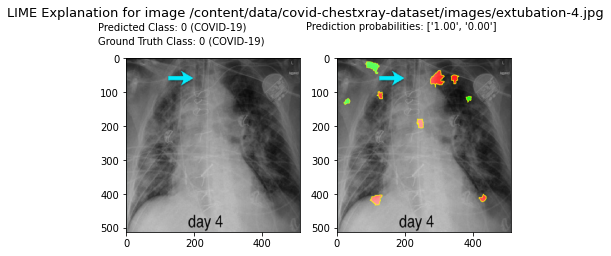

In [0]:
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
from skimage.segmentation import mark_boundaries
from lime.lime_image import SegmentationAlgorithm

def visualize_explanation(orig_img, explanation, img_filename, label, probs, class_names, label_to_see='top', dir_path=None):

    # Plot original image on the left
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(orig_img)

    # Plot the image and its explanation on the right
    if label_to_see == 'top':
        label_to_see = explanation.top_labels[0]
    explanation.image = orig_img
    temp, mask = explanation.get_image_and_mask(label_to_see, positive_only=False, num_features=10, hide_rest=False)
    ax[1].imshow(mark_boundaries(temp, mask))

    # Display some information about the example
    pred_class = np.argmax(probs)
    fig.text(0.5, 0.9, "Prediction probabilities: " + str(['{:.2f}'.format(probs[i]) for i in range(len(probs))]),
             fontsize=10)
    fig.text(0.02, 0.9, "Predicted Class: " + str(pred_class) + ' (' + class_names[int(pred_class)] + ')', fontsize=10)
    if label is not None:
        fig.text(0.02, 0.85, "Ground Truth Class: " + str(class_names.index(label)) + ' (' + label + ')', fontsize=10)
    fig.suptitle("LIME Explanation for image " + img_filename, fontsize=13)
    fig.tight_layout()

    # Save the image
    filename = None
    if dir_path is not None:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        filename = os.path.join(dir_path, img_filename.split('/')[-1] + '_exp_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + '.svg')
        plt.savefig(filename)
    return filename

lime_test_generator.reset()
for idx in range(NUM_TEST_IMG):
  x, _ = lime_test_generator.next()
  x = np.squeeze(x, axis=0)

  # Get the corresponding original image (no preprocessing)
  orig_img = cv2.imread(data['TEST']['filename'][idx])
  new_dim = tuple(lime_dict['IMG_DIM'])
  orig_img = cv2.resize(orig_img, new_dim, interpolation=cv2.INTER_NEAREST)     # Resize image

  # Make a prediction for this image and retrieve a LIME explanation for the prediction
  start_time = datetime.datetime.now()

  def predict(x):
      '''
      Helper function for LIME explainer. Runs model prediction on perturbations of the example.
      :param x: List of perturbed examples from an example
      :return: A numpy array constituting a list of class probabilities for each predicted perturbation
      '''
      y = lime_model.predict(x)  # Run prediction on the perturbations
      if y.shape[1] == 1:
          probs = np.concatenate([1.0 - y, y], axis=1)  # Compute class probabilities from the output of the model
      else:
          probs = y
      return probs

  # Algorithm for superpixel segmentation. Parameters set to limit size of superpixels and promote border smoothness
  segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=2.25, max_dist=50, ratio=0.1, sigma=0.15)
  # Generate explanation for the example
  explanation = lime_explainer.explain_instance(x.astype(np.double), predict, num_features=lime_dict['NUM_FEATURES'], num_samples=lime_dict['NUM_SAMPLES'], segmentation_fn=segmentation_fn)
  probs = predict(np.expand_dims(x, axis=0))

  print("Explanation time = " + str((datetime.datetime.now() - start_time).total_seconds()) + " seconds")

  # Get image filename and label
  img_filename = data['TEST']['filename'][idx]
  label = data['TEST']['label'][idx]

  # Rearrange prediction probability vector to reflect original ordering of classes in project config
  probs = [probs[0][lime_dict['CLASSES'].index(c)] for c in lime_test_generator.class_indices]

  # Visualize the LIME explanation and optionally save it to disk
  file_path = lime_dict['IMG_PATH']
  explanation_filenames = []
  if lime_dict['COVID_ONLY'] == True:
      label_to_see = lime_test_generator.class_indices['COVID-19']
  else:
      label_to_see = 'top'
  expalanation_filename = visualize_explanation(orig_img, explanation, img_filename, label, probs, lime_dict['CLASSES'], label_to_see=label_to_see,
                        dir_path=file_path)
  explanation_filenames.append(expalanation_filename)